# Link prediction на датасете fb15k237

Я буду использовать алгоритм DistMult из библиотеки StellarGraph. Кроме того в ней из коробки доступен датасет fb15k237.

В качестве метрик качества я буду использовать MRR и Hits at 10 посчитанные по отфильтрованной выборке, то есть когда известные ребра игнорируются при подсчете рангов.

Установим все зависимости и библиотеки.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from stellargraph import datasets, utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import DistMult

from IPython.display import HTML

## Скачаем данные

Датасет можно получить сразу же с разбиенем на train, test и val, каждый набор состоит из троек subject, relation, object.

In [4]:
fb15k_237 = datasets.FB15k_237()
display(HTML(fb15k_237.description))
fb15k_237_graph, fb15k_237_train, fb15k_237_test, fb15k_237_valid = fb15k_237.load()

Посмотрим на описание датасета.

In [5]:
print(fb15k_237_graph.info())

StellarDiGraph: Directed multigraph
 Nodes: 14541, Edges: 310116

 Node types:
  default: [14541]
    Features: none
    Edge types: default-/american_football/football_team/current_roster./sports/sports_team_roster/position->default, default-/award/award_category/category_of->default, default-/award/award_category/disciplines_or_subjects->default, default-/award/award_category/nominees./award/award_nomination/nominated_for->default, default-/award/award_category/winners./award/award_honor/award_winner->default, ... (232 more)

 Edge types:
    default-/award/award_nominee/award_nominations./award/award_nomination/award_nominee->default: [16391]
        Weights: all 1 (default)
        Features: none
    default-/film/film/release_date_s./film/film_regional_release_date/film_release_region->default: [15568]
        Weights: all 1 (default)
        Features: none
    default-/award/award_nominee/award_nominations./award/award_nomination/award->default: [14051]
        Weights: all 1 (de

## Тренируем модель

Я прочитал в примерах из документации DistMult как лучше инициализировать параметры модели.

In [8]:
epochs = 100
embedding_dimension = 100
negative_samples = 2

In [10]:
fb15k_237_gen = KGTripleGenerator(
    fb15k_237_graph, batch_size=len(fb15k_237_train) // 10  # ~100 бачей на одну эпоху
)

fb15k_237_distmult = DistMult(
    fb15k_237_gen,
    embedding_dimension=embedding_dimension,
    embeddings_regularizer=regularizers.l2(1e-8),
)

fb15k_237_inp, fb15k_237_out = fb15k_237_distmult.in_out_tensors()

fb15k_237_model = Model(inputs=fb15k_237_inp, outputs=fb15k_237_out)
fb15k_237_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)],
)

Входы для тренировки создаются методом `KGTripleGenerator.flow`, он принимает Pandas DataFrame с колонками `source`, `label` и `target`, в котором каждая строчка - это известное true ребро в графе. Параметр `negative_samples` отвечает за то, сколько случайных ребер генерируется для каждого положительного ребра, чтобы использовать их как negative samples во время тренировки.

In [11]:
fb15k_237_train_gen = fb15k_237_gen.flow(
    fb15k_237_train, negative_samples=negative_samples, shuffle=True
)
fb15k_237_valid_gen = fb15k_237_gen.flow(fb15k_237_valid, negative_samples=negative_samples)

Обучаем модель.

In [12]:
fb15k_237_es = callbacks.EarlyStopping(monitor="val_loss", patience=50)
fb15k_237_history = fb15k_237_model.fit(
    fb15k_237_train_gen,
    validation_data=fb15k_237_valid_gen,
    epochs=epochs,
    callbacks=[fb15k_237_es],
    verbose=0,
)

Визуализируем процесс обучения.

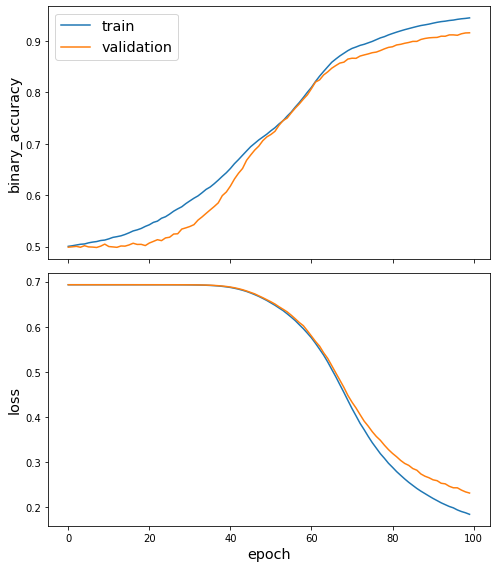

In [13]:
utils.plot_history(fb15k_237_history)

## Инференс модели

Мы натренировали модель, теперь можно ее применить. Мы будем для каждого ребра из теста `E = (h, l, t)` сравнивать его скор со скорами для всех "мутированных" ребер `(h', l, t)` и `(h, l, t')`. "Сырой" ранг - это количество "мутированных" ребер, у которых предсказанный скор выше чем у настоящего `E`.

In [14]:
fb15k_237_smaller_gen = KGTripleGenerator(fb15k_237_graph, batch_size=5000)

fb15k_237_raw_ranks, fb15k_237_filtered_ranks = fb15k_237_distmult.rank_edges_against_all_nodes(
    fb15k_237_smaller_gen.flow(fb15k_237_test), fb15k_237_graph
)

Вспомогательная функция, чтобы посчитать метрики по массиву рангов.

In [15]:
def results_as_dataframe(mrr, hits_at_10):
    return pd.DataFrame(
        [(mrr, hits_at_10)], columns=["mrr", "hits at 10"], index=["filtered"],
    )

def summarise(ranks):
    return results_as_dataframe(np.mean(1 / ranks), np.mean(ranks <= 10))

Результаты.

In [17]:
summarise(fb15k_237_filtered_ranks)

,mrr,hits at 10
filtered,0.124625,0.235586


Результаты мягко говоря не очень:(
    
Тем не менее с задачей обучить модель я справился.